# SENTIMENT ANALYSIS PROJECT

## 1. Introduction

Here, we are going to analyze the review of beauty products sold at Amazon in 2004-2018. The data is  retrieved from Stanford University SNAP website at link: http://deepx.ucsd.edu/public/jianmo/amazon/categoryFilesSmall/All_Beauty_5.json.gz. We will start with importing necessary libraries and reading the data into a DataFrame.

In [1]:
# import necessary libraries

import pandas as pd
import gzip
import json

import datetime as dt

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('stopwords')

from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import unicodedata
#import contractions
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize 
from nltk.stem import PorterStemmer, WordNetLemmatizer
import re


from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
# unzip and read the data into a DataFrame

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('All_Beauty_5.json.gz')

## 2. Data Wrangling

Let's first check 10 random rows of the dataset.

In [3]:
df.sample(10)

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
1247,5.0,False,"09 5, 2012",A2LY3LPGRERLPW,B000FI4S1E,NaN,finicky buyer,I had a hard time finding this product in the ...,another love for St. Ives,1346803200,NaN,NaN
1084,5.0,True,"12 8, 2014",A2KA5PR2AKM7ZU,B000FI4S1E,NaN,susanb1222,The price for an Hermes product is the best,Five Stars,1417996800,NaN,NaN
860,5.0,False,"11 11, 2012",ACA81N25RHH2N,B0009RF9DW,{'Size:': ' 8'},L Lovera,"Don't just take my word for it, you must try i...",Spa in a bottle,1352592000,NaN,NaN
2535,5.0,True,"05 6, 2016",A2KV46HMWY1YWB,B0012Y0ZG2,{'Size:': ' 586'},Kindle Customer,Smells wonderful. Feels great on hands and arm...,Must have product,1462492800,NaN,NaN
702,5.0,True,"11 28, 2014",A13B2J5IBGS8Y2,B0009RF9DW,{'Size:': ' 22'},Pam,Love this-but believe it is no longer availabl...,Five Stars,1417132800,NaN,NaN
4616,4.0,True,"06 28, 2014",A3KHIT48AYHC0L,B001OHV1H4,{'Size:': ' 5'},DLB,Have used this product for the past 7 months. ...,H2O+ aquatics natural shampoo,1403913600,NaN,NaN
434,5.0,True,"12 20, 2013",AZJMUP77WBQZQ,B00006L9LC,{'Size:': ' 329'},S. Foote,THIS WAS A GIFT PURCHASED LAST YEAR FOR MY DAU...,GIFT,1387497600,NaN,NaN
5103,5.0,False,"05 12, 2018",AUS96J3A7A9MK,B00006L9LC,{'Size:': ' Small'},Kirk Wiper,"Got both products from this seller, shampoo an...",Selenium is awesome!,1526083200,NaN,NaN
2377,5.0,True,"02 15, 2017",A14R11HV2H7AVW,B0012Y0ZG2,{'Size:': ' 1 Pound'},Diane Gordon,Also a very good product,Five Stars,1487116800,NaN,NaN
2914,5.0,True,"05 24, 2014",A24OO89UB5PY7J,B0012Y0ZG2,{'Size:': ' 179'},JD,I have been buying this body wash for abut a y...,Simple Clean,1400889600,NaN,NaN


We will get some more information with the info method.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5269 entries, 0 to 5268
Data columns (total 12 columns):
overall           5269 non-null float64
verified          5269 non-null bool
reviewTime        5269 non-null object
reviewerID        5269 non-null object
asin              5269 non-null object
style             4624 non-null object
reviewerName      5269 non-null object
reviewText        5264 non-null object
summary           5264 non-null object
unixReviewTime    5269 non-null int64
vote              552 non-null object
image             98 non-null object
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 499.1+ KB


There are 5269 rows and 12 columns in the dataset. We have 9 columns of datatype string, 2 numerical columns and a column of datatype boolean. Columns 'style', 'summary', 'vote' and 'image' have missing values. The columns are:

1. overall - rating of the product
2. verified - no explanation at source
3. reviewTime - time of the review (raw)
4. reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
5. asin - ID of the product, e.g. 0000013714
6. style - a disctionary of the product metadata, e.g., "Format" is "Hardcover"
7. reviewerName - name of the reviewer
8. reviewText - text of the review
9. summary - summary of the review
10. unixReviewTime - time of the review (unix time)
11. vote - helpful votes of the review
12. image - no explanation at source

Let's see how many entries are missing from each column:

In [5]:
df.isnull().sum()

overall              0
verified             0
reviewTime           0
reviewerID           0
asin                 0
style              645
reviewerName         0
reviewText           5
summary              5
unixReviewTime       0
vote              4717
image             5171
dtype: int64

We will check if column names have any white spaces that will interfere with our analysis:

In [6]:
df.columns

Index(['overall', 'verified', 'reviewTime', 'reviewerID', 'asin', 'style',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'vote',
       'image'],
      dtype='object')

Column names don't have any white spaces. We will first drop 'vote' and 'image' columns since most of their values are missing. Further, the 'verified' column doesn't provide any useful information for our analysis. We are not interested in the 'reviewerName' and we have a 'reviewerID' column to track the reviewers. Similarly, we don't need the 'style' column since we have the 'asin' column to track the products. So, we will also drop the columns 'verified', 'reviewerName' and 'style'.

In [7]:
df.drop(['vote', 'image', 'verified', 'reviewerName', 'style'], axis = 1, inplace = True)

# check the first rows of the new DataFrame
df.head()

,overall,reviewTime,reviewerID,asin,reviewText,summary,unixReviewTime
0,5.0,"09 1, 2016",A3CIUOJXQ5VDQ2,B0000530HU,As advertised. Reasonably priced,Five Stars,1472688000
1,5.0,"11 14, 2013",A3H7T87S984REU,B0000530HU,Like the oder and the feel when I put it on my...,Good for the face,1384387200
2,1.0,"08 18, 2013",A3J034YH7UG4KT,B0000530HU,I bought this to smell nice after I shave. Wh...,Smells awful,1376784000
3,5.0,"05 3, 2011",A2UEO5XR3598GI,B0000530HU,HEY!! I am an Aqua Velva Man and absolutely lo...,Truth is There IS Nothing Like an AQUA VELVA MAN.,1304380800
4,5.0,"05 6, 2011",A3SFRT223XXWF7,B00006L9LC,If you ever want to feel pampered by a shampoo...,Bvlgari Shampoo,1304640000


We will combine two string columns into one: 'summary and reviewText'. We will fill the missing values with an empty string so that we can keep the value of one column if the other has a missing value. 

In [8]:
df['reviewText'] = df['reviewText'].fillna('') + ' ' + df['summary'].fillna('')

#check the 5th row of 'reviewText' so that we can compare with the table above 
df['reviewText'][4]


"If you ever want to feel pampered by a shampoo this one is the one.  It smells like a wonderful perfume and cleans your hair until it shines plus adding a fullness that most other shampoo's don't give you.  It is expensive, but worth it! Bvlgari Shampoo"

Let's check if the 'reviewText' column still has any missing values after combining with 'summary'. 

In [9]:
df['reviewText'].isnull().sum()

0

We were able to fill in the missing values of the two columns with each other because the missing values were at different rows. Now, let's convert 'reviewTime' to datetime object to have a more 'user-friendly' column.

In [10]:
df['reviewTime'] = pd.to_datetime(df['reviewTime'])

# check random 5 rows to see the new 'reviewTime'
df.sample(5)

,overall,reviewTime,reviewerID,asin,reviewText,summary,unixReviewTime
5174,5.0,2015-11-11,A156IOMOA59X7N,B00CQ0LN80,I always use this so was as expected Five Stars,Five Stars,1447200000
605,5.0,2016-02-13,A39WH9DUE96U1P,B0009RF9DW,The best soaking liquid you'll find. I lived ...,Best soaking liquid ever.,1455321600
1849,5.0,2015-03-24,A71OPGFA90NJL,B000URXP6E,Love love love. I've got sensitive skin and I ...,Love.,1427155200
4768,5.0,2014-08-11,A914TQVHI872U,B00EYZY6LQ,This Fekkai conditioning mousse impressed.\n\n...,Very special...definitely and positively a win...,1407715200
2066,5.0,2013-10-18,A2MTXSVB9MC8IO,B000URXP6E,Matrix Biolage Fortifying conditioner is excel...,Love it! Leaves my hair smooth and strong,1382054400


Now that we added the column 'summary' to the column 'reviewText' and have a more 'user-friendly' time column, we can also drop the redundant columns 'summary' and 'unixReviewTime'. 

In [11]:
df.drop(['summary', 'unixReviewTime'], axis = 1, inplace = True)
df.head()

,overall,reviewTime,reviewerID,asin,reviewText
0,5.0,2016-09-01,A3CIUOJXQ5VDQ2,B0000530HU,As advertised. Reasonably priced Five Stars
1,5.0,2013-11-14,A3H7T87S984REU,B0000530HU,Like the oder and the feel when I put it on my...
2,1.0,2013-08-18,A3J034YH7UG4KT,B0000530HU,I bought this to smell nice after I shave. Wh...
3,5.0,2011-05-03,A2UEO5XR3598GI,B0000530HU,HEY!! I am an Aqua Velva Man and absolutely lo...
4,5.0,2011-05-06,A3SFRT223XXWF7,B00006L9LC,If you ever want to feel pampered by a shampoo...


Let's see if we have any duplicates:

In [12]:
df[df.duplicated(keep=False)].count()

overall       2047
reviewTime    2047
reviewerID    2047
asin          2047
reviewText    2047
dtype: int64

We are going to drop the duplicates.

In [13]:
df.drop_duplicates(inplace = True)

# check to see how many rows left
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4219 entries, 0 to 5268
Data columns (total 5 columns):
overall       4219 non-null float64
reviewTime    4219 non-null datetime64[ns]
reviewerID    4219 non-null object
asin          4219 non-null object
reviewText    4219 non-null object
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 197.8+ KB


Here, we will check the unique number of features.

In [14]:
print('The total number of reviewers is: {}'. format(df.reviewerID.nunique()))
print('The total number of unique reviews is: {}'. format(df.reviewText.nunique()))
print('The total number of reiewed products is: {}'. format(df.asin.nunique()))
print('The total number of review days is: {}'. format(df.reviewTime.nunique()))
print('The total number of reviews is: {}'. format(len(df)))

The total number of reviewers is: 991
The total number of unique reviews is: 1370
The total number of reiewed products is: 85
The total number of review days is: 883
The total number of reviews is: 4219


991 unique customers wrote 1370 unique reviews for 85 products in 883 unique days.

We are going to drop the rows with duplicate reviews.

In [15]:
df.drop_duplicates(subset='reviewText', keep='first', inplace=True)

In [16]:
# check the remaining DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1370 entries, 0 to 5268
Data columns (total 5 columns):
overall       1370 non-null float64
reviewTime    1370 non-null datetime64[ns]
reviewerID    1370 non-null object
asin          1370 non-null object
reviewText    1370 non-null object
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 64.2+ KB


Now, let's check the summary statistics of the ratings in 'overall' column:

In [17]:
df.describe()

,overall
count,1370.000000
mean,4.647445
std,0.837714
min,1.000000
25%,5.000000
50%,5.000000
75%,5.000000
max,5.000000


The standard deviation is 0.84 and the mean is 4.65. Over 5.0, 4.65 is quite a good average.

## 3. EDA

Here, we will do an Exploratory Data Analysis. We will look at the features.

### a. 'reviewTime'

In [18]:
# check the dates covered
print(df['reviewTime'].min(), '-', df['reviewTime'].max())

2004-09-21 00:00:00 - 2018-08-23 00:00:00


The data covers the period between September 2004 and August 2018. Here is the plot of number of reviews by year:

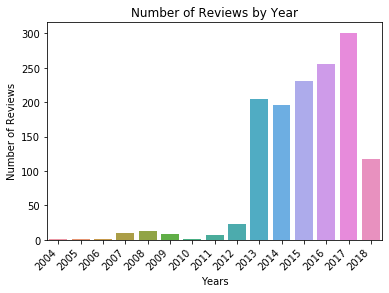

In [19]:
df['reviewYear'] = df.reviewTime.dt.year
yr = df.reviewYear.value_counts()
yr_figure = sns.barplot(x = yr.index, y = yr.values)
yr_figure.set(title = 'Number of Reviews by Year')
yr_figure.set(xlabel = 'Years')
yr_figure.set(ylabel = 'Number of Reviews')
yr_figure.set_xticklabels(yr_figure.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

The number of reviews increased generally and reached the maximum in 2017. The 2018 data covers the period until August 23. There is a huge leap from 2012 to 2013.

### b. 'overall'

In [20]:
# check the values of 'overall'
df.overall.value_counts()

5.0    1095
4.0     153
3.0      66
1.0      30
2.0      26
Name: overall, dtype: int64

Let's see it in a plot.

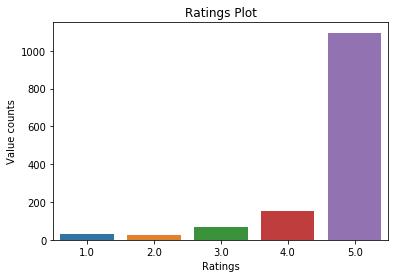

In [21]:
ov = df.overall.value_counts()
my_figure = sns.barplot(x = ov.index, y = ov.values)
my_figure.set(title = 'Ratings Plot')
my_figure.set(xlabel = 'Ratings')
my_figure.set(ylabel = 'Value counts')
plt.show()

Most of the ratings are 5.0.

We will categorize 'overall' values > 3 as 1 and 'overall' values <= 3 as 0 to do a binary classification. 

In [22]:
df['overall'] = df['overall'].apply(lambda x: 1 if x > 3 else 0)
df.head()

,overall,reviewTime,reviewerID,asin,reviewText,reviewYear
0,1,2016-09-01,A3CIUOJXQ5VDQ2,B0000530HU,As advertised. Reasonably priced Five Stars,2016
1,1,2013-11-14,A3H7T87S984REU,B0000530HU,Like the oder and the feel when I put it on my...,2013
2,0,2013-08-18,A3J034YH7UG4KT,B0000530HU,I bought this to smell nice after I shave. Wh...,2013
3,1,2011-05-03,A2UEO5XR3598GI,B0000530HU,HEY!! I am an Aqua Velva Man and absolutely lo...,2011
4,1,2011-05-06,A3SFRT223XXWF7,B00006L9LC,If you ever want to feel pampered by a shampoo...,2011


In [23]:
# check the values of 'overall' as a fraction
df.overall.value_counts() / len(df.overall)

1    0.910949
0    0.089051
Name: overall, dtype: float64

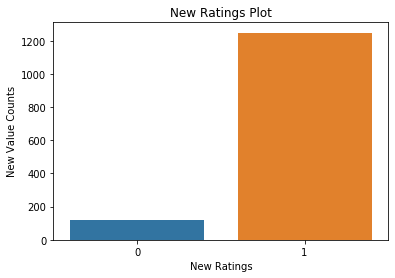

In [24]:
# see the new plot
ov = df.overall.value_counts()
new_figure = sns.barplot(x = ov.index, y = ov.values)
new_figure.set(title = 'New Ratings Plot')
new_figure.set(xlabel = 'New Ratings')
new_figure.set(ylabel = 'New Value Counts')
plt.show()

A pie plot will provide a better visualization of the new rating ratios:

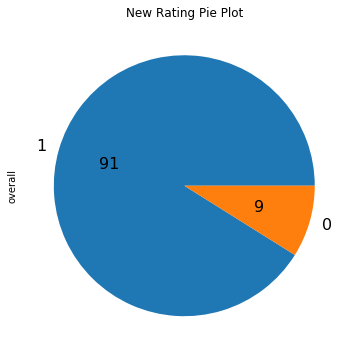

In [25]:
df['overall'].value_counts().plot.pie(autopct='%.0f', fontsize=16, figsize=(6, 6))
plt.title('New Rating Pie Plot')
plt.show()

91% of the reviews are positive.

Here, we are going to look at the yearly ratio of positive reviews.

In [26]:
reviews_by_year = df.groupby(['reviewYear']).agg({'overall':['size', 'sum']})
reviews_by_year.columns = [' '.join(col).strip() for col in reviews_by_year.columns.values]
reviews_by_year = reviews_by_year.reset_index()
reviews_by_year['% of Positive Review'] = [x/y for x,y in zip(reviews_by_year['overall sum'], 
                                                              reviews_by_year['overall size'])]
reviews_by_year.columns = ['Year', 'Number_Total_Reviews', 'Number_Positive_Reviews', 
                       'Ratio_Positive_Reviews']
reviews_by_year

,Year,Number_Total_Reviews,Number_Positive_Reviews,Ratio_Positive_Reviews
0,2004,1,1,1.000000
1,2005,1,1,1.000000
2,2006,1,1,1.000000
3,2007,10,7,0.700000
4,2008,13,3,0.230769
5,2009,9,7,0.777778
6,2010,1,1,1.000000
7,2011,7,5,0.714286
8,2012,23,22,0.956522
9,2013,204,181,0.887255


Let's see this in a plot.

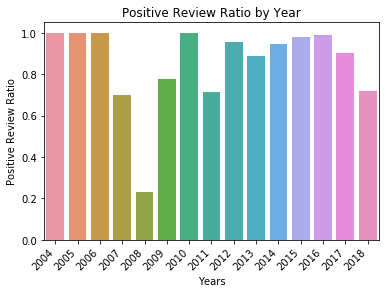

In [27]:
ratio_figure = sns.barplot(x = reviews_by_year.Year.values, 
                         y = reviews_by_year.Ratio_Positive_Reviews.values)
ratio_figure.set(title = 'Positive Review Ratio by Year')
ratio_figure.set(xlabel = 'Years')
ratio_figure.set(ylabel = 'Positive Review Ratio')
ratio_figure.set_xticklabels(yr_figure.get_xticklabels(), 
                             rotation=45, horizontalalignment='right')
plt.show()

There is a minimum 23% in 2008. Year 2018 until August is also not too high with 72% positive reviews.

### c. 'reviewerID'

Let's see if some customers write more reviews:

In [28]:
df['reviewerID'].value_counts().head()

AUX122XW8ONG6     11
A1UQBFCERIP7VJ    10
A11QGZ39A7ZF0X    10
A22CW0ZHY3NJH8     8
AKJHHD5VEH7VG      8
Name: reviewerID, dtype: int64

There are customers who provide valuable feedback by writing more reviews. It would be beneficial to keep track of these customers.

### d. 'asin'

Now, we are going to check if some products get more reviews.

In [29]:
df['asin'].value_counts().head(10)

B00006L9LC    475
B0009RF9DW    378
B00W259T7G    127
B0010ZBORW     49
B001LNODUS     32
B01E7UKR38     23
B01DLR9IDI     21
B00DY59MB6     18
B0013NB7DW     18
B000URXP6E     16
Name: asin, dtype: int64

There are 3 products which were reviewed more than 100 times. It would be beneficial to invest more in these products.

## 4. NLP

First, we are going to check the length of the reviews.

In [30]:
length_reviews = df.reviewText.str.len()
print('\n longest review: ', max(length_reviews), '\n shortest review: ', min(length_reviews))


 longest review:  5282 
 shortest review:  9


Now, we will tokenize the text.

In [31]:
word_tokens = [word_tokenize(review) for review in df.reviewText]

# check the resulting tokens
print(word_tokens[0])
print(word_tokens[1])

['As', 'advertised', '.', 'Reasonably', 'priced', 'Five', 'Stars']
['Like', 'the', 'oder', 'and', 'the', 'feel', 'when', 'I', 'put', 'it', 'on', 'my', 'face', '.', 'I', 'have', 'tried', 'other', 'brands', 'but', 'the', 'reviews', 'from', 'people', 'I', 'know', 'they', 'prefer', 'the', 'oder', 'of', 'this', 'brand', '.', 'Not', 'hard', 'on', 'the', 'face', 'when', 'dry', '.', 'Does', 'not', 'leave', 'dry', 'skin', '.', 'Good', 'for', 'the', 'face']


Here, we will normalize the text, i.e. we will use a function that strips the html tags, converts the text to lower_case, lemmatizes the text, removes extra lines, accented or special characters, digits and stopwords.

In [32]:
# html_tags removal
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

# accented_chars removal
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

# special_characters removal
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

# Lemmatization
lemmatizer=WordNetLemmatizer()
                     
def lemmatize_text(text):
    text = " ".join(lemmatizer.lemmatize(w) for w in text.split(' '))
    return text

# Creating stopwordlist and editing 
stopword_list= stopwords.words('english')
    
# "no" and "not" may give us information so those are removed from stop lists
stopword_list.remove('no')
stopword_list.remove('not')
                     
def remove_stopwords(text, stop_words=stopword_list):
    tokens = [w for w in nltk.word_tokenize(text) if w not in stop_words]
    return ' '.join(tokens)    

                     

def normalize_text(text, html_stripping=True, accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=True):
    
    # strip HTML
    if html_stripping:
        text = strip_html_tags(text)
        
    # remove accented characters
    if accented_char_removal:
        text = remove_accented_chars(text)

    # lowercase the text    
    if text_lower_case:
        text = text.lower()
    
    # remove extra newlines
    text = re.sub(r'[\r|\n|\r\n]+', ' ',text)
    
    # remove special characters and\or digits    
    if special_char_removal:
        # insert spaces between special characters to isolate them    
        special_char_pattern = re.compile(r'([{.(-)!}])')
        text = special_char_pattern.sub(" \\1 ", text)
        text = remove_special_characters(text, remove_digits=remove_digits)  
    
    # remove extra whitespace and underscore
    text = re.sub(' +', ' ', text)
    text = re.sub('_+', '', text)
    
    # lemmatize text
    if text_lemmatization:
        text = lemmatize_text(text)
        
    # remove stopwords
    if stopword_removal:
        text = remove_stopwords(text)
       
    return text

Let's see the function in action:

In [33]:
df['clean_text'] = df['reviewText'].map(lambda text: normalize_text(text))
df.head(1)

,overall,reviewTime,reviewerID,asin,reviewText,reviewYear,clean_text
0,1,2016-09-01,A3CIUOJXQ5VDQ2,B0000530HU,As advertised. Reasonably priced Five Stars,2016,advertised reasonably priced five star


Now, we will plot a word cloud to get a pictorial feel of which words occur the most in the reviews.

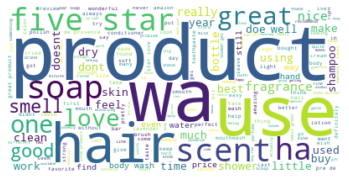

In [34]:
%matplotlib inline
import pdb
big_list = ''
#big_list = [big_list + row  for row in df.reviewText]
big_list = [''.join(row) for row in df.clean_text]
big_string = ','.join(big_list)

my_cloud = WordCloud(background_color = 'white').generate(big_string)
plt.imshow(my_cloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

It's time to prepare the data for machine learning. Now, we will use Tfidf Vectorizer to capture the frequency ratios each word appears in the reviews.

In [35]:
vect = TfidfVectorizer(max_features = 1000, 
                       ngram_range = (1, 1),
                       stop_words = ENGLISH_STOP_WORDS, 
                       token_pattern = r'\b[^\d\W][^\d\W]+\b')
vect.fit(df.clean_text)
X = vect.transform(df.clean_text)

# transform the resulting sparse matrix into an array
my_array = X.toarray()

# back to df, assign column names
X_df = pd.DataFrame(my_array, columns = vect.get_feature_names())

X_df.head()


,able,absolutely,absorbs,accidentally,acid,active,actual,actually,add,added,...,wrinkle,wrong,year,yellow,yes,youll,younger,youre,yummy,zest
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.080761,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.117025,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 5. Machine Learning

Here, we will fit a Logistic Regression Model to some part of the data and test its accuracy on the reamining part of our data.

In [36]:
y = df.overall

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 123,
                                                    stratify = y)

logreg = LogisticRegression(penalty = 'l2', C = 1)
logreg.fit(X_train, y_train)
y_predicted = logreg.predict(X_test)
print('accuracy on training set: ', logreg.score(X_train, y_train))
print('accuracy on test set: ', accuracy_score(y_test, y_predicted))
print('confusion matrix ratios: \n', confusion_matrix(y_test, y_predicted) / len(y_test))

accuracy on training set:  0.9133211678832117
accuracy on test set:  0.9124087591240876
confusion matrix ratios: 
 [[0.         0.08759124]
 [0.         0.91240876]]


C:\Users\My_Laptop\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Our Logistic Regression Model had an accuracy score of 0.91.